In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sn
import sklearn.metrics as metrics
from sklearn.preprocessing import label_binarize
from IPython.display import display, HTML

In [3]:
with open("../IFCNetCore_Classes.json", "r") as f:
    class_names = json.load(f)

In [4]:
def calc_metrics(model_name, class_names):
    data = np.load(model_name + "Probs.npz")
    labels, probs = data["labels"], data["probs"]
    binary_labels = label_binarize(labels, classes=list(range(len(class_names))))
    precision, recall, _ = metrics.precision_recall_curve(binary_labels.ravel(), probs.ravel())
    auc = metrics.auc(recall, precision)
    
    return data, precision, recall, auc

In [5]:
mvcnn_data, mvcnn_precision, mvcnn_recall, mvcnn_auc = calc_metrics("MVCNN", class_names)
dgcnn_data, dgcnn_precision, dgcnn_recall, dgcnn_auc = calc_metrics("DGCNN", class_names)
meshnet_data, meshnet_precision, meshnet_recall, meshnet_auc = calc_metrics("MeshNet", class_names)
lowres_data, lowres_precision, lowres_recall, lowres_auc = calc_metrics("IFCGeomLowRes", class_names)
uniform_data, uniform_precision, uniform_recall, uniform_auc = calc_metrics("IFCGeomUniform", class_names)
#detailed_data, detailed_precision, detailed_recall, detailed_auc = calc_metrics("IFCGeomDetailed", class_names)

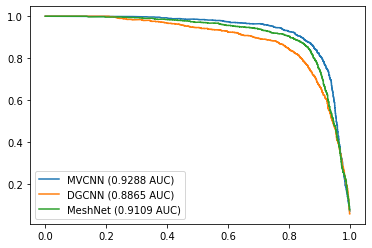

In [6]:
plt.plot(mvcnn_recall, mvcnn_precision, label=f"MVCNN ({mvcnn_auc:.4f} AUC)")
plt.plot(dgcnn_recall, dgcnn_precision, label=f"DGCNN ({dgcnn_auc:.4f} AUC)")
plt.plot(meshnet_recall, meshnet_precision, label=f"MeshNet ({meshnet_auc:.4f} AUC)")
plt.legend()
plt.savefig("../reports/figures/pr_curve_all.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
def plot_class_pr_curves(meshnet_data, dgcnn_data, mvcnn_data, class_names, classes_to_plot, rows, cols):
    plt.figure(figsize=(12, 7))
    data = {"MVCNN": mvcnn_data, "DGCNN": dgcnn_data, "MeshNet": meshnet_data}
    
    plt.subplot(rows, cols, 1)
    plt.title("Overall")
    plt.plot(mvcnn_recall, mvcnn_precision, label=f"MVCNN ({mvcnn_auc:.4f} AUC)")
    plt.plot(dgcnn_recall, dgcnn_precision, label=f"DGCNN ({dgcnn_auc:.4f} AUC)")
    plt.plot(meshnet_recall, meshnet_precision, label=f"MeshNet ({meshnet_auc:.4f} AUC)")
    plt.legend(loc="lower left")
    
    plot_count = 2
    for i, class_name in enumerate(class_names):
        if class_name not in classes_to_plot: continue
        plt.subplot(rows, cols, plot_count)
        plt.title(class_name)
        for model_name, model_data in data.items():
            labels, probs = model_data["labels"], model_data["probs"]
            precision, recall, thresholds = metrics.precision_recall_curve(labels, probs[:, i], pos_label=i)
            auc = metrics.auc(recall, precision)
            plt.plot(recall, precision, label=f"{model_name} ({auc:.4f} AUC)")
        plot_count += 1
        plt.legend(loc="lower left")
    plt.savefig("../reports/figures/class_pr_curves.png", dpi=300, bbox_inches="tight")
    plt.show()

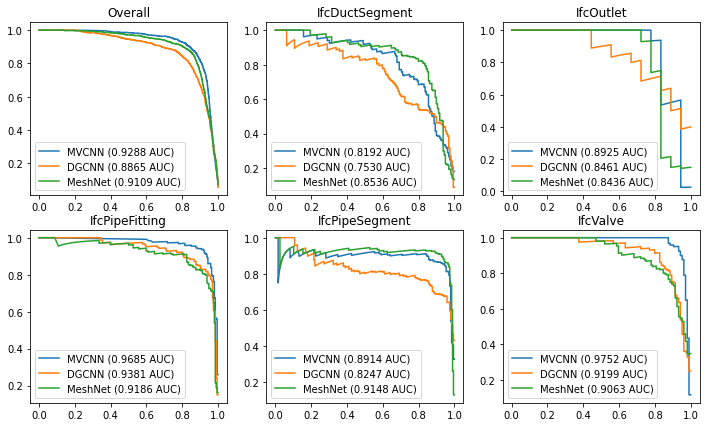

In [8]:
classes_to_plot = ["IfcDuctSegment", "IfcPipeFitting", "IfcPipeSegment", "IfcOutlet", "IfcValve"]
plot_class_pr_curves(meshnet_data, dgcnn_data, mvcnn_data, class_names, classes_to_plot, 2, 3)

In [9]:
def plot_model_pr_curves(labels, probs, class_names, classes_to_plot, fname):
    for i, class_name in enumerate(class_names):
        if class_name not in classes_to_plot: continue
        precision, recall, thresholds = metrics.precision_recall_curve(labels, probs[:, i], pos_label=i)
        auc = metrics.auc(recall, precision)
        plt.plot(recall, precision, label=f"{class_name} ({auc:.4f} AUC)")
    plt.legend()
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if fname:
        plt.savefig("../reports/figures/" + fname, dpi=300, bbox_inches="tight")
    plt.show()

In [10]:
plot_model_pr_curves(dgcnn_labels, dgcnn_probs, class_names, classes_to_plot, fname="dgcnn_pr_curves.png")

NameError: name 'dgcnn_labels' is not defined

In [ ]:
plot_model_pr_curves(meshnet_labels, meshnet_probs, class_names, classes_to_plot, fname="meshnet_pr_curves.png")

In [ ]:
plot_model_pr_curves(mvcnn_labels, mvcnn_probs, class_names, classes_to_plot, fname="mvcnn_pr_curves.png")

In [12]:
def plot_class_accuracies(data, class_names):
    result_table = []
    for key, value in data.items():
        model_accs = {"Model": key}
        overall_acc = 0
        labels, probs = value["labels"], value["probs"]
        predictions = np.argmax(probs, axis=1)
        correct_predictions = predictions[predictions == labels]
        for i, cn in enumerate(class_names):
            acc = len(correct_predictions[correct_predictions == i])/len(labels[labels == i])
            model_accs[cn] = np.round(acc*100, 2)
            overall_acc += acc
        overall_acc /= len(class_names)
        model_accs["Overall"] = np.round(overall_acc*100, 2)
        result_table.append(model_accs)
    df = pd.DataFrame(result_table)
    pd.set_option("display.max_columns", None)
    display(df)
    df.to_csv("ClassAccuracies.csv", index=False)

In [13]:
plot_class_accuracies({
    "MVCNN": mvcnn_data,
    "MeshNet": meshnet_data,
    "DGCNN": dgcnn_data,
    "MinkLowRes": lowres_data,
    "MinkUniform": uniform_data
}, class_names)

,Model,IfcAirTerminal,IfcBeam,IfcCableCarrierFitting,IfcCableCarrierSegment,IfcDoor,IfcDuctFitting,IfcDuctSegment,IfcFurniture,IfcLamp,IfcOutlet,IfcPipeFitting,IfcPipeSegment,IfcPlate,IfcRailing,IfcSanitaryTerminal,IfcSlab,IfcSpaceHeater,IfcStair,IfcValve,IfcWall,Overall
0,MVCNN,88.73,77.38,96.13,81.13,97.85,87.69,67.92,94.03,66.67,83.33,96.39,93.33,76.43,94.49,85.29,82.24,71.05,87.50,91.35,91.93,85.54
1,MeshNet,79.58,60.71,90.32,84.91,98.92,87.69,79.25,74.63,59.26,72.22,85.57,94.36,85.35,92.13,86.76,93.42,78.95,93.75,77.88,90.68,83.32
2,DGCNN,80.99,72.62,86.45,68.55,97.85,87.18,63.52,80.60,59.26,44.44,92.27,96.92,80.89,93.70,77.94,89.47,60.53,93.75,78.85,76.40,79.11
3,MinkLowRes,84.51,73.81,71.61,92.45,98.92,72.82,71.70,92.54,74.07,83.33,67.01,72.82,66.88,94.49,80.15,90.13,71.05,100.00,88.46,91.93,81.93
4,MinkUniform,82.39,73.81,76.77,79.25,100.00,78.46,84.28,94.03,81.48,83.33,80.93,73.33,71.34,96.85,75.74,82.24,78.95,100.00,72.12,95.03,83.02
